In [1]:
from __future__ import print_function
import os
import cv2
import torch
from torch.nn import DataParallel
import numpy as np
import time
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg

from models import *
from config import Config
from test import load_image, cosin_metric, lfw_test, get_lfw_list, get_featurs, get_feature_dict

In [2]:
opt = Config()
if opt.backbone == 'resnet18':
    model = resnet_face18(opt.use_se)
elif opt.backbone == 'resnet34':
    model = resnet34()
elif opt.backbone == 'resnet50':
    model = resnet50()

model = DataParallel(model)
# load_model(model, opt.test_model_path)
model.load_state_dict(torch.load(opt.test_model_path))
model.to(torch.device("cuda"))

DataParallel(
  (module): ResNetFace(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): IRBlock(
        (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=1)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): IRBlock(
        (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [3]:
model.eval()

DataParallel(
  (module): ResNetFace(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): IRBlock(
        (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=1)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): IRBlock(
        (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [4]:
def img_pair_to_arr(path1, path2):
    img1 = load_image(path1)
    img2 = load_image(path2)
    
    orig_img1 = mpimg.imread(path1)
    orig_img2 = mpimg.imread(path2)

    data1 = torch.from_numpy(img1)
    data1 = data1.to(torch.device("cuda"))

    data2 = torch.from_numpy(img2)
    data2 = data2.to(torch.device("cuda"))

    output1 = model(data1)
    output2 = model(data2)

    arr1 = output1.cpu().detach().numpy()
    arr2 = output2.cpu().detach().numpy()

    arr1 = np.hstack((arr1[0], arr1[1]))
    arr2 = np.hstack((arr2[0], arr2[1]))
    return arr1, arr2, orig_img1, orig_img2

def check_pair(path1, path2):
    arr1, arr2, img1, img2 = img_pair_to_arr(path1, path2)
    sim_orig = cosin_metric(arr1, arr2)
    plt.rcParams['figure.figsize'] = [4, 4]

    plt.matshow(img1,  cmap='viridis')
    plt.matshow(img2, cmap='viridis')
    return sim_orig

In [11]:
def sims_labels(fe_dict, pair_list=opt.lfw_test_list):
    with open(pair_list, 'r') as fd:
        pairs = fd.readlines()
    sims = []
    labels = []
    for pair in pairs:
        splits = pair.split()
        fe_1 = fe_dict[splits[0]]
        fe_2 = fe_dict[splits[1]]
        label = int(splits[2])
        sim = cosin_metric(fe_1, fe_2)

        sims.append(sim)
        labels.append(label)
    return sims, labels

def far_frr(imposter_scores, targets_scores):
    #FAR (False Acceptance Rate)
    far = []
    thresholds_list = []
    for threshold in range(100):
        num = 0

        for x in imposter_scores:
                if abs(x*100)>threshold:
                        num+=100/len(imposter_scores)
        far.append(num)
        thresholds_list.append(threshold)

    far = np.array(far)
    print('FAR: ',far)
    print('-----------------------------------------------------------')
    
    #FRR (False Rejection Rate)
    frr = []
    for threshold in range(100):
        num = 0

        for x in targets_scores:
                if abs(x*100)<threshold:
                        num+=100/len(imposter_scores)
        frr.append(num)

    frr = np.array(frr)
    print('FRR: ',frr)
    print('-----------------------------------------------------------')

    return far, frr, thresholds_list

In [6]:
identity_list = get_lfw_list(opt.lfw_test_list)
img_paths = [os.path.join(opt.lfw_root, each) for each in identity_list]
features, cnt = get_featurs(model, img_paths, batch_size=10)
fe_dict = get_feature_dict(identity_list, features)

In [16]:
sims, labels = sims_labels(fe_dict)
far, frr, thresholds_list = far_frr(sims[3000:], sims[:3000])

FAR:  [1.00000000e+02 9.24000000e+01 8.44333333e+01 7.73666667e+01
 7.05666667e+01 6.48666667e+01 5.87333333e+01 5.37666667e+01
 4.83000000e+01 4.33666667e+01 3.77666667e+01 3.35333333e+01
 2.90333333e+01 2.45000000e+01 2.19666667e+01 1.95666667e+01
 1.64333333e+01 1.36666667e+01 1.13666667e+01 9.56666667e+00
 8.06666667e+00 7.16666667e+00 6.00000000e+00 4.96666667e+00
 4.06666667e+00 3.30000000e+00 2.93333333e+00 2.30000000e+00
 1.93333333e+00 1.60000000e+00 1.30000000e+00 1.13333333e+00
 9.33333333e-01 7.00000000e-01 6.00000000e-01 5.66666667e-01
 5.33333333e-01 4.33333333e-01 4.33333333e-01 2.66666667e-01
 2.00000000e-01 2.00000000e-01 1.66666667e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 3.33333333e-02 3.33333333e-02
 3.33333333e-02 3.33333333e-02 3.33333333e-02 3.33333333e-02
 3.33333333e-02 3.33333333e-02 3.33333333e-02 3.33333333e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.

In [17]:
#EER (Equal Error Rate)
EER_threshold = np.argmin(abs(frr-far))
EER = far[EER_threshold]

In [18]:
EER, frr[EER_threshold], far[EER_threshold]

(1.3000000000000007, 1.3000000000000007, 1.3000000000000007)

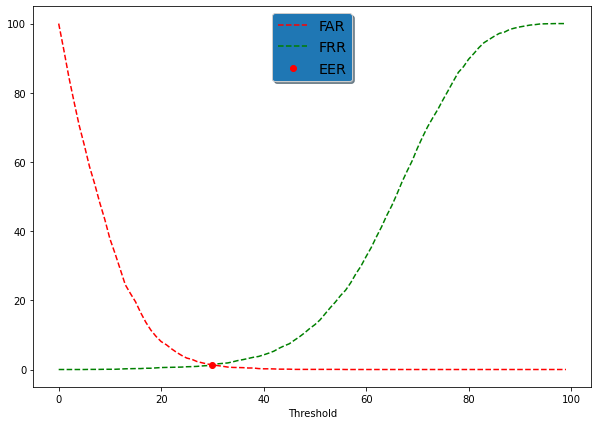

In [19]:
plt.rcParams['figure.figsize'] = [10, 7]
fig, ax = plt.subplots()

ax.plot(thresholds_list, far, 'r--', label='FAR')
ax.plot(thresholds_list, frr, 'g--', label='FRR')
plt.xlabel('Threshold')

plt.plot(EER_threshold, EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [20]:
print('EER = {}%'.format(round((EER ),2)))

EER = 1.3%


In [ ]:
lfw_test(model, img_paths, identity_list, opt.lfw_test_list, opt.test_batch_size)

0.7867442

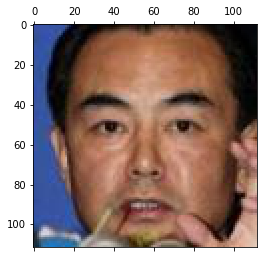

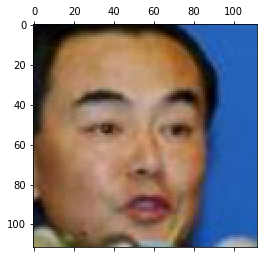

In [21]:
path1 = '/home/sondors/job/lfw/positive/ac9ec425-0611-457e-b70f-2133af38372e/f18bf757-4973-4b71-bca2-398519cc750b.jpg'
path2 = '/home/sondors/job/lfw/positive/ac9ec425-0611-457e-b70f-2133af38372e/1655d380-dc06-4fad-b958-fea20029057b.jpg'
check_pair(path1, path2)

0.088495895

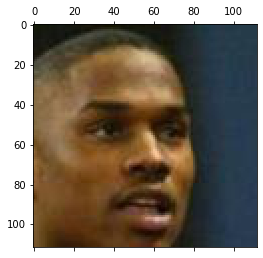

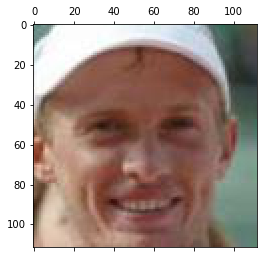

In [22]:
path1 = '/home/sondors/job/lfw/negative/ccf70e97-7ba1-4bbd-965a-00da9ddd09f5/0ac99dba-e192-406c-8f4e-30c97b6a9290.jpg'
path2 = '/home/sondors/job/lfw/negative/ccf70e97-7ba1-4bbd-965a-00da9ddd09f5/6c36ea52-516c-4aad-b0df-7d66d6c9d7a9.jpg'
check_pair(path1, path2)